In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import tqdm

import os
from multiprocessing import Process, Pool
import sys
sys.path.append('../src/')

from mutations_extractor_with_context import release_mutations_from_two_seqs

In [2]:
PATH_TO_MULAL = '../data/mulal.fasta'

In [3]:
%%time

reader = SeqIO.parse(PATH_TO_MULAL, 'fasta')
ref = next(reader)


def get_nums(rec):
    mutations = release_mutations_from_two_seqs(ref.seq, rec.seq)
    mut_num = len(mutations)
    return mut_num


threads = 24
with Pool(threads) as p:
    a = p.map(get_nums, reader)

CPU times: user 47.6 s, sys: 33.4 s, total: 1min 21s
Wall time: 12min 55s


In [4]:
len(a)

1139387

In [14]:
b = [x for x in a if x < 100]

In [15]:
len(b)

1129204

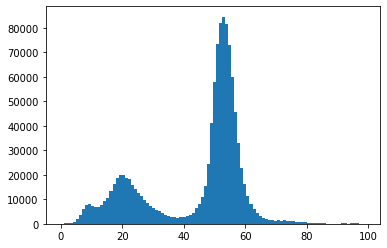

In [16]:
plt.hist(b, bins=100)
plt.show()

In [16]:
import os
from multiprocessing import Process, Pool


def doubler(number):
    """
    Функция умножитель на два
    """
    result = number * 2
    proc = os.getpid()
    print('{0} doubled to {1} by process id: {2}'.format(
        number, result, proc))
 
 
if __name__ == '__main__':
    numbers = [5, 10, 15, 20, 25]
    procs = []
    
    for index, number in enumerate(numbers):
        proc = Process(target=doubler, args=(number,))
        procs.append(proc)
        proc.start()
    
    for proc in procs:
        proc.join()

5 doubled to 10 by process id: 9241210 doubled to 20 by process id: 92413

15 doubled to 30 by process id: 92419
20 doubled to 40 by process id: 92425
25 doubled to 50 by process id: 92430


In [17]:
def f(x):
    return x*x

if __name__ == '__main__':
    with Pool(5) as p:
        print(p.map(f, [1, 2, 3]))

[1, 4, 9]
